In [ ]:
from numpy.random import exponential
from lifelines.fitters import ParametericUnivariateFitter
import autograd.numpy as np
np.random.seed(10)

Suppose we generate data from a mixture of exponentials with no censoring (this could be extended to censoring, but for our application we don't observe censoring). Furthermore, the data is not observed directly, but our instrument has binned the data into integer buckets. 

This model is easy to handle in lifelines. Instead of worrying about the binning, we can treat the system as an interval-censoring problem. That is, if an observation landed in the $i$th bin, then we know the _true_ data point occured somewhere between the $i$th and $i+1$th bin. This is precisely interval censoring. 

We can use *lifelines* custom model semantics to create a mixture model as well. The true model is:

$$S(t) = p \exp\left(\frac{t}{\lambda_1}\right) + (1-p)\exp\left(\frac{t}{\lambda_2}\right)$$

Therefore the cumulative hazard is:

$$H(t) = -\log(S(t)) = -\log\left(p \exp\left(\frac{t}{\lambda_1}\right) + (1-p)\exp\left(\frac{t}{\lambda_2}\right)\right) $$

In [80]:
T = [exponential(20) for _ in range(10000)] + [exponential(40) for _ in range(500)]
counts_obs = np.bincount(T)
T_obs = np.arange(np.amax(T))

(0, 100)

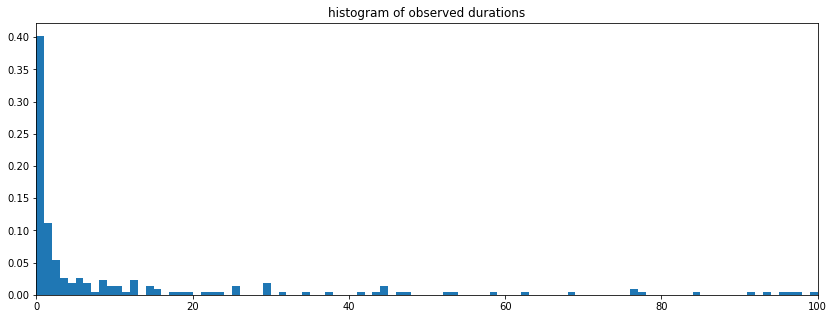

In [81]:
plt.figure(figsize=(14,5))
plt.hist(counts_obs, bins=T_obs, density=True)
plt.title("histogram of observed durations")
plt.xlim(0, 100)

In [82]:
# To help the model avoid the "non-identibility" problem, we can set the upper bound of the first lambda to be 
# the average of the observed data, and the lower bound of the second lambda to the same value. Why? 
# We wish to partition the postive reals into two halves, each containing one of the lambdas. The sample
# of the data is v = p(lambda1) + (1-p)lambda2, which has the property lambda1 < v < lambda2, thefore  
# it will split the positive reals. 
mean_obs = np.average(T_obs, weights=counts_obs)
print(mean_obs)

20.75914285714286


In [83]:

class MixtureExponential(ParametericUnivariateFitter):

    _fitted_parameter_names = ['lambda1', 'lambda2', 'p']
    _bounds = [(0, mean_obs), (mean_obs, None), (0, 1)]

    def _cumulative_hazard(self, params, t):
        l1, l2, p = params
        return -np.log(p * np.exp(-t/l1) + (1-p) * np.exp(-t/l2))


model = MixtureExponential()
model.fit_interval_censoring(
    lower_bound=T_obs, 
    upper_bound=T_obs+1, 
    weights=counts_obs, 
    initial_point=np.array([mean_obs/2, mean_obs*2, 0.5])
)

model.print_summary()

<lifelines.MixtureExponential: fitted with 10500 total observations, 10500 interval-censored observations>
number of observations = 10500
number of events observed = 0
    log-likelihood = -42593.81
        hypothesis = lambda1 != 10.3796, lambda2 != 41.5183, p != 0.5

---
         coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda1 20.76      0.63       19.53       21.98 <0.005    203.27
lambda2 38.17     17.50        3.86       72.47   0.85      0.24
p        0.97      0.06        0.86        1.09 <0.005     49.37
